In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB6
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report
import keras



In [ ]:
classes=[]
filename=r"/content/drive/MyDrive/Data/MRI Images/"
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)


['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']


In [ ]:
X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)):
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)        


100%|██████████| 105/105 [00:01<00:00, 64.97it/s]


In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape
lb = LabelEncoder()


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

print(y_train)

[3 3 2 ... 3 3 0]


In [ ]:
EfficientNet=EfficientNetB6(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

165249024/165234480 [==============================] - 3s 0us/step


In [ ]:
tf.random.set_seed(79)
model = EfficientNet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=EfficientNet.input, outputs = model)
opt = Adam(
    learning_rate=0.000023,
    epsilon=1e-08,
    clipnorm=1.0)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 


In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 160, 160, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 161, 161, 3)  0           ['normalization[0][0]']      

In [ ]:
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)


history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=70,
    batch_size=8,callbacks=[early_stopping_cb])


Epoch 1/70
348/348 [==============================] - 148s 263ms/step - loss: 0.9598 - accuracy: 0.6165 - val_loss: 0.8686 - val_accuracy: 0.6911
Epoch 2/70
348/348 [==============================] - 86s 247ms/step - loss: 0.5259 - accuracy: 0.8188 - val_loss: 0.5094 - val_accuracy: 0.8638
Epoch 3/70
348/348 [==============================] - 87s 251ms/step - loss: 0.3447 - accuracy: 0.8839 - val_loss: 0.2653 - val_accuracy: 0.9329
Epoch 4/70
348/348 [==============================] - 86s 247ms/step - loss: 0.2282 - accuracy: 0.9231 - val_loss: 0.2133 - val_accuracy: 0.9390
Epoch 5/70
348/348 [==============================] - 87s 251ms/step - loss: 0.1636 - accuracy: 0.9400 - val_loss: 0.2046 - val_accuracy: 0.9411
Epoch 6/70
348/348 [==============================] - 88s 254ms/step - loss: 0.1443 - accuracy: 0.9554 - val_loss: 0.1525 - val_accuracy: 0.9634
Epoch 7/70
348/348 [==============================] - 86s 246ms/step - loss: 0.0890 - accuracy: 0.9756 - val_loss: 0.1589 - val_a

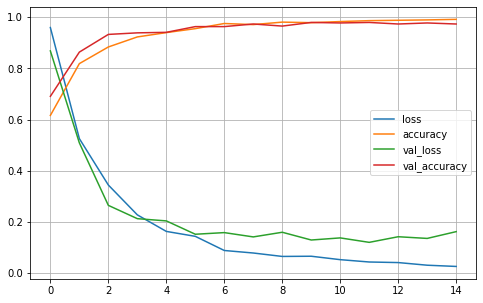

In [ ]:
#plot loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)


In [ ]:
loss, accuracy = model.evaluate(X_test,y_test)


16/16 [==============================] - 2s 150ms/step - loss: 0.1208 - accuracy: 0.9797


In [ ]:
print('Accuracy: %f' % (accuracy*100))

Accuracy: 97.967482


In [ ]:
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 97.967 
 loss : 0.121


In [ ]:
y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred)

In [ ]:
pd.Series(pred_labels).value_counts()

meningioma_tumor    142
glioma_tumor        136
pituitary_tumor     135
no_tumor             79
dtype: int64

Text(70.8, 0.5, 'Predicted class')

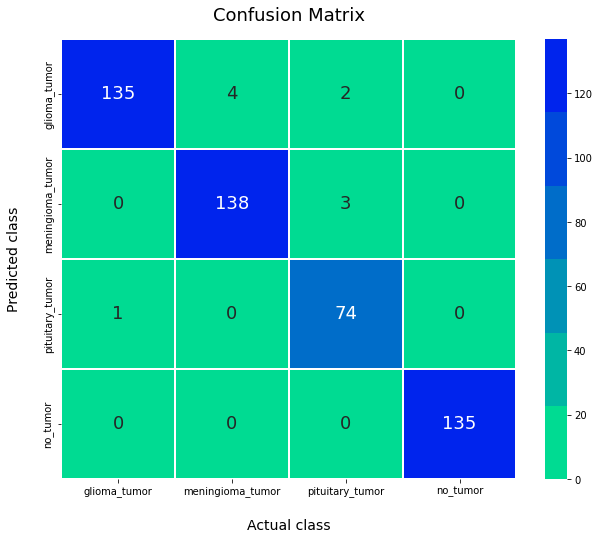

In [ ]:
cm = confusion_matrix(y_test,pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

In [ ]:
print(classification_report(y_test,pred,target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.96      0.97       141
meningioma_tumor       0.97      0.98      0.98       141
 pituitary_tumor       0.94      0.99      0.96        75
        no_tumor       1.00      1.00      1.00       135

        accuracy                           0.98       492
       macro avg       0.98      0.98      0.98       492
    weighted avg       0.98      0.98      0.98       492

